<center>

<h1 style="font-size: 40px;">SVM</h1>

</center>

The aim of the exercise is to implement the SVM algorithm with a kernel function:
- Linear
- RBF
In both cases, using the standard hinge loss function and L2 regularization, and optimize the hyperparameters:
- $C$ - regularization parameter
In both cases, choose appropriate ranges for optimization. The training should be conducted following good ML practices (splitting into training and testing sets) and using metrics such as:
- Accuracy
- Confusion matrix
- Precision
- Recall
Test the algorithm on a dataset of students preparing for an exam, training the classifier to determine how passing the exam depends on individual factors. Assume that the exam is passed if each of the individual part scores is greater than $60\%$.

Dataset: [ Students Performance in Exams](https://www.kaggle.com/datasets/whenamancodes/students-performance-in-exams/)

In [ ]:
%pip install matplotlib
%pip install seaborn
%pip install pandas
%pip install numpy
%pip install ipympl
%pip install tabulate
%pip install ipywidgets
%pip install scikit-learn
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
%matplotlib inline

In [2]:
def predict(X, w, b):
    return np.sign(np.dot(w.T, X.T) + b).astype(int)

def calc_b(X, y, w):
    b_tmp = y - np.dot(w.T, X.T)
    return np.mean(b_tmp)

def calc_w(alpha, y, X):
    return np.dot(X.T, np.multiply(alpha,y))

def h(X, w, b):
    return np.sign(np.dot(w.T, X.T) + b).astype(int)

def Error(x_k, y_k, w, b):
    return h(x_k, w, b) - y_k

def compute_L_H(C, alpha_prime_j, alpha_prime_i, y_j, y_i):
    if(y_i != y_j):
        return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
    else:
        return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    
def get_rnd_int(a, b, z):
    i = z
    while i == z:
        i = rnd.randint(a, b)
    return i

# Kernel functions

In [3]:
def kernel_linear(x1, x2, **kwargs):
    return np.dot(x1, x2.T)

def kernel_polynomial(x1, x2, p=3):
    return (1 + np.dot(x1, x2.T)) ** p

def kernel_RBF(x1, x2, gamma=0.1):
    return np.exp(-np.linalg.norm(np.subtract(x1, x2)) ** 2 / (2 * gamma ** 2))

# Main SVM algorithm loop

In [4]:
def svm_fit(X, y, kernel, C=1, epsilon=0.001, max_iter=1000, kernel_params=None):
    n = X.shape[0]
    alpha = np.zeros((n))
    count = 0
    while True:
        count += 1
        alpha_prev = np.copy(alpha)
        for j in range(0, n):
            i = get_rnd_int(0, n-1, j)  # Get random int i~=j
            x_i, x_j, y_i, y_j = X[i, :], X[j, :], y[i], y[j]
            k_ij = kernel(x_i, x_i, **kernel_params) + kernel(x_j, x_j, **kernel_params) - 2 * kernel(x_i, x_j, **kernel_params)
            if k_ij == 0:
                continue
            alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
            (L, H) = compute_L_H(C, alpha_prime_j, alpha_prime_i, y_j, y_i)

            # Compute model parameters
            w = calc_w(alpha, y, X)
            b = calc_b(X, y, w)

            # Compute Errors
            Err_i = Error(x_i, y_i, w, b)
            Err_j = Error(x_j, y_j, w, b)

            # Set new alpha values
            alpha[j] = alpha_prime_j + float(y_j * (Err_i - Err_j)) / k_ij
            alpha[j] = max(alpha[j], L)
            alpha[j] = min(alpha[j], H)

            alpha[i] = alpha_prime_i + y_i * y_j * (alpha_prime_j - alpha[j])

        # Check convergence
        diff = np.linalg.norm(alpha - alpha_prev)
        if diff < epsilon:
            break

        if count >= max_iter:
            break
    # Compute final model parameters
    w = calc_w(alpha, y, X)
    b = calc_b(X, y, w)

    return w, b


In [19]:
def print_values(y_test, y_pred, matrix=True):

    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))

    if matrix:
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize = (6, 4))
        sns.heatmap(conf_matrix, 
                    annot = True, 
                    cmap = 'RdPu')
        plt.title('Confusion Matrix')

In [6]:
def plot_for_test_size(kernel, X_encoded, y):
    
    test_size = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
    results = []
    for i in test_size:
        X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=i, random_state=0)
        w, b = svm_fit(X_train, y_train, kernel, C=1, epsilon=0.01, max_iter=1000, kernel_params={})
        y_pred = predict(X_test, w, b)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        results.append({'test_size': i, 'accuracy': accuracy, 'precision': precision, 'recall': recall})

    dataframe = pd.DataFrame(results)

    plt.figure(figsize=(20,8))
    plt.plot(dataframe['test_size'], dataframe['accuracy'], label='accuracy')
    plt.plot(dataframe['test_size'], dataframe['precision'], label='precision')
    plt.plot(dataframe['test_size'], dataframe['recall'], label='recall')
    plt.xlabel('Test size')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [7]:
df = pd.read_csv('exams.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


# Charts of gender, race, parental level of education, type of lunch, and test preparation course

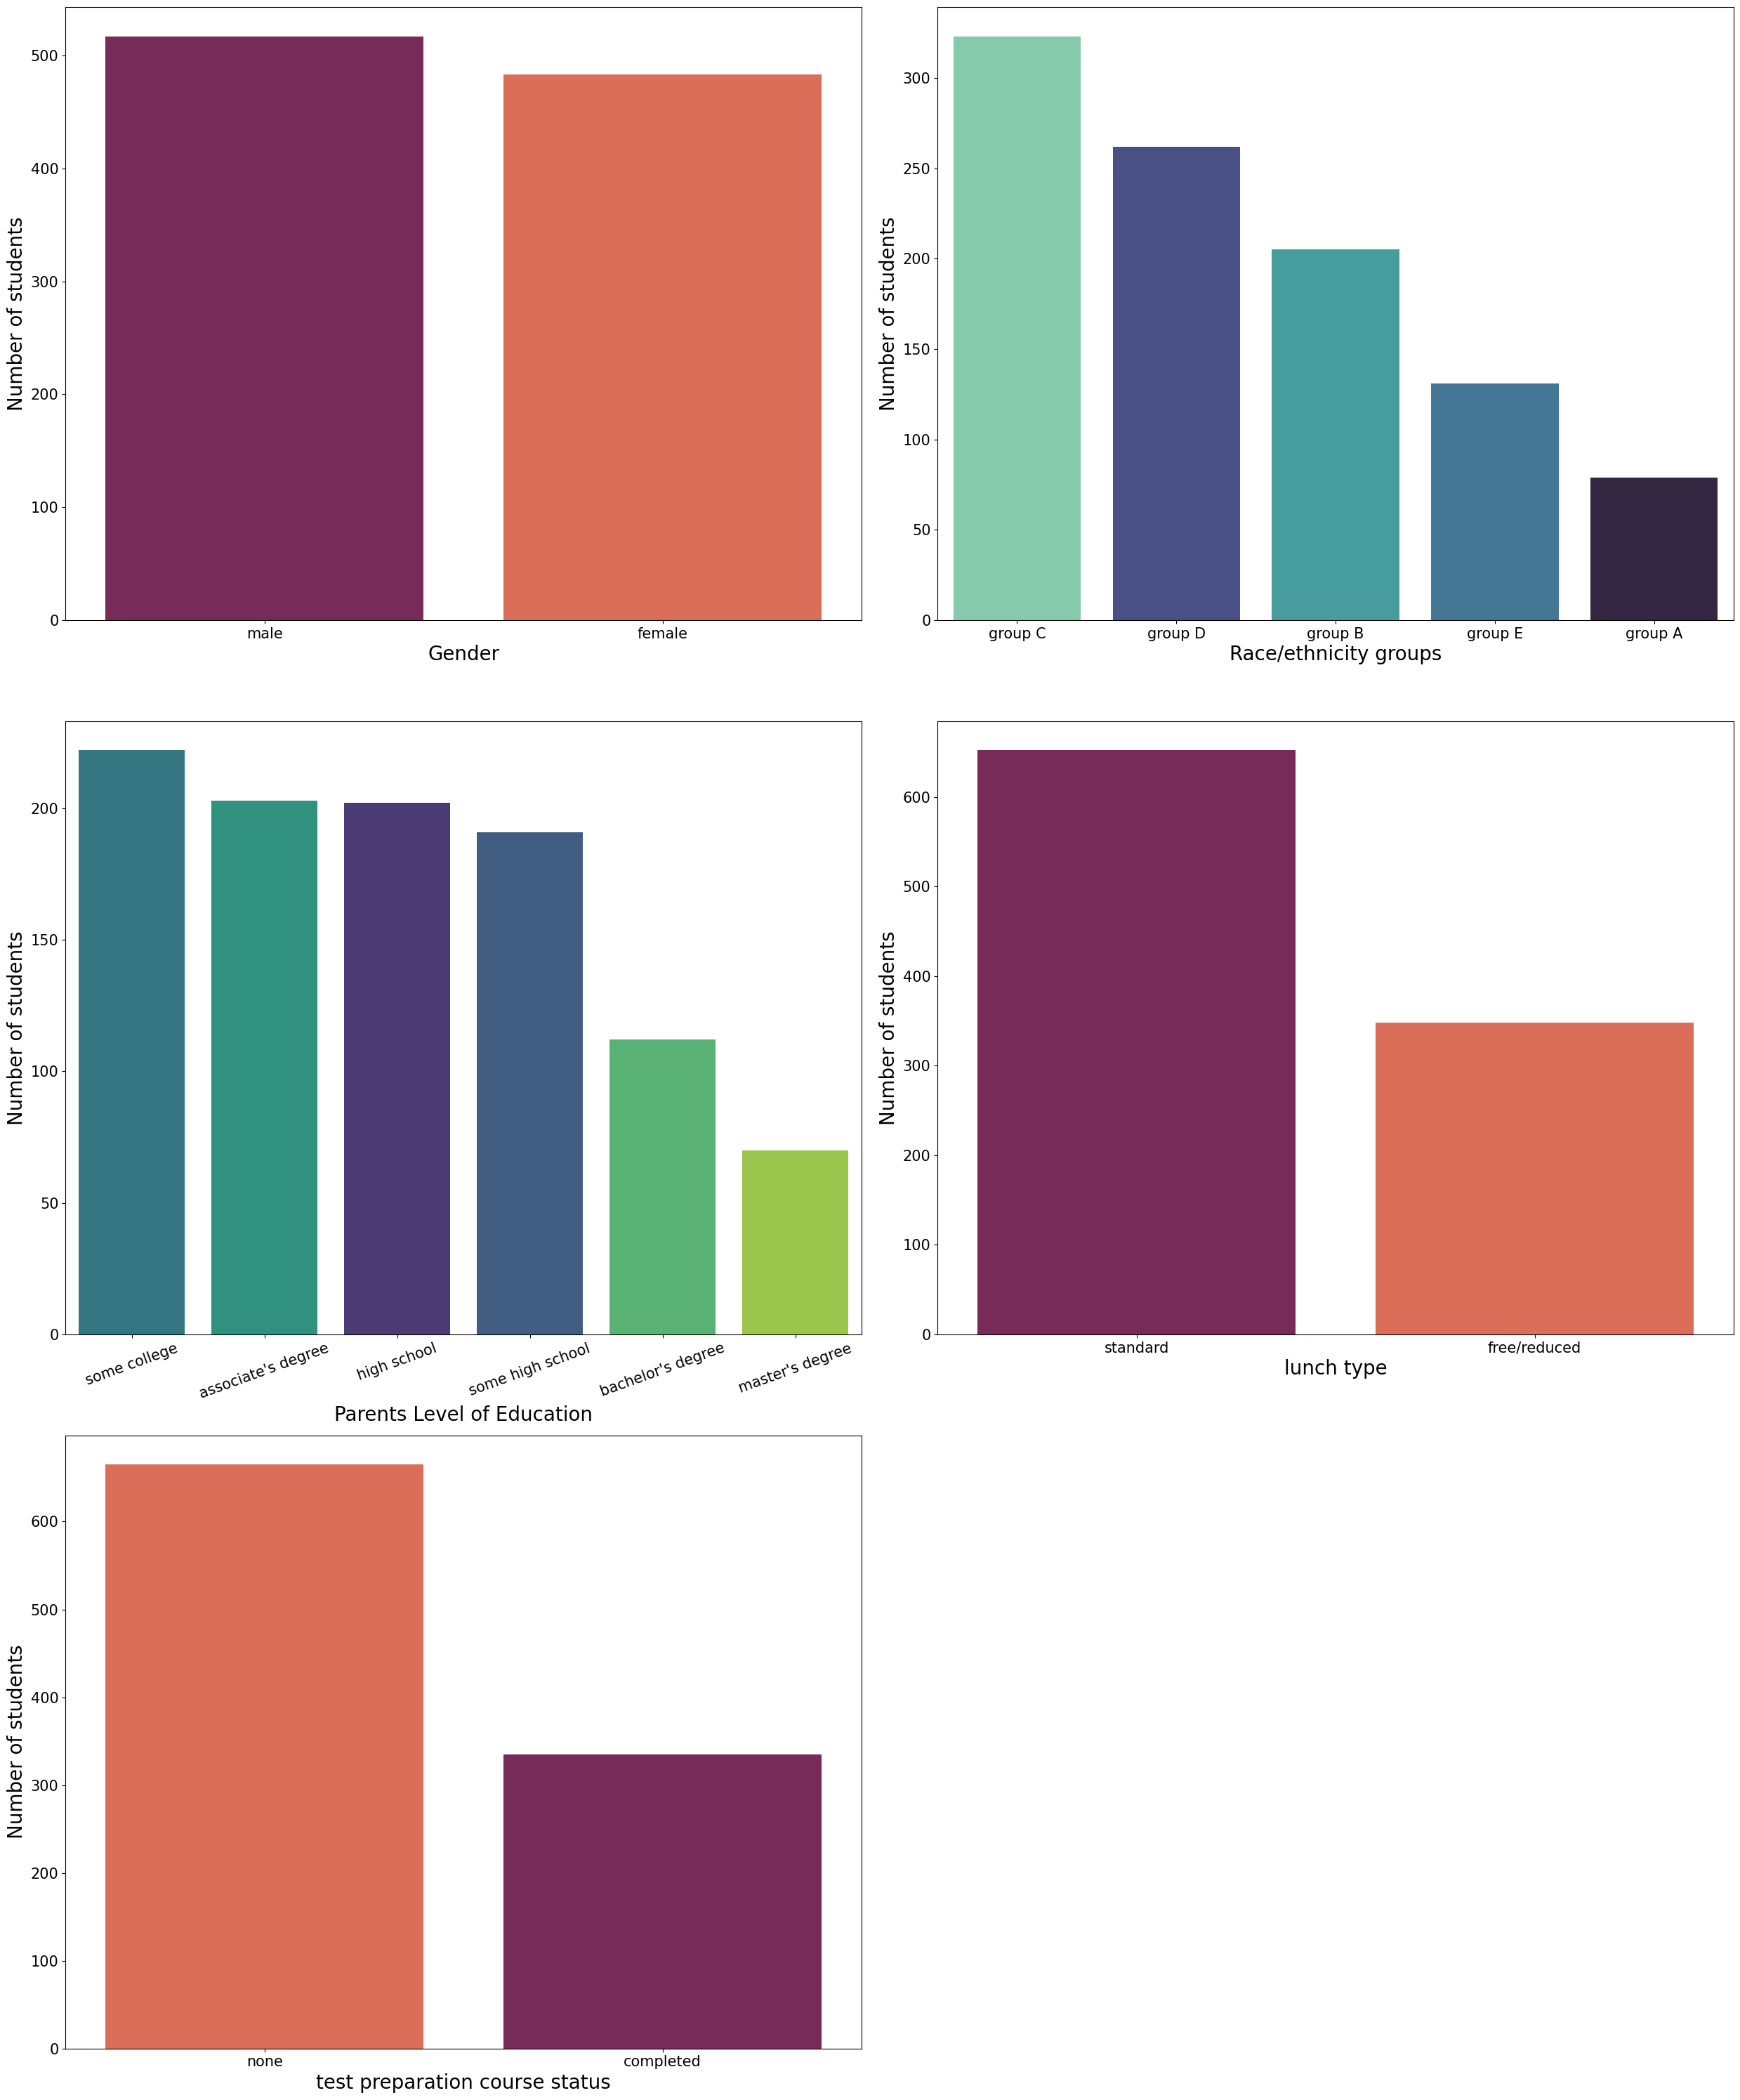

In [8]:
#Plot numbers and definition
fig , ax = plt.subplots(nrows=3 , ncols= 2 , figsize=(25,30))

#Gender plot
ax = plt.subplot(3, 2, 1)
sns.countplot(data=df, x='gender', ax=ax, palette='rocket', hue='gender', legend=False)
plt.ylabel('Number of students', size=20)
plt.xlabel('Gender', size=20)
plt.yticks(size=15)
plt.xticks(size=15)


#Race/ethnicity plot
ax = plt.subplot(3,2,2)
sns.countplot(data=df, x ='race/ethnicity', palette='mako', hue='race/ethnicity', legend=False, order= df['race/ethnicity'].value_counts().index)
plt.ylabel('Number of students', size = 20)
plt.xlabel('Race/ethnicity groups' , size = 20)
plt.yticks(size=15)
plt.xticks(size=15)

#Parental education level plot
ax = plt.subplot(3,2,3)
sns.countplot(data=df, x='parental level of education', ax=ax, palette='viridis', hue='parental level of education', legend=False, order=df['parental level of education'].value_counts().index)
plt.ylabel('Number of students', size = 20)
plt.xlabel('Parents Level of Education' , size = 20)
plt.yticks(size=15)
plt.xticks(size=15 , rotation =20)

#Lunch type plot
ax = plt.subplot(3,2,4)
sns.countplot(data= df, x = 'lunch',ax=ax, palette='rocket', hue='lunch', legend=False, order= df['lunch'].value_counts().index)
plt.ylabel('Number of students', size = 20)
plt.xlabel('lunch type' , size = 20)
plt.yticks(size=15)
plt.xticks(size=15)

#Test Preparation course status plot
ax = plt.subplot(3,2,5)
sns.countplot(data= df, x = 'test preparation course', ax=ax, palette='rocket', hue='test preparation course', legend=False, order= df['test preparation course'].value_counts().index)
plt.ylabel('Number of students', size = 20)
plt.xlabel('test preparation course status' , size = 20)
plt.yticks(size=15)
plt.xticks(size=15)

fig.tight_layout()

ax = plt.subplot(3,2,6)
fig.delaxes(ax)

# Charts of scores for each test:
- Math score
- Reading score
- Writing score

<Axes: ylabel='Count'>

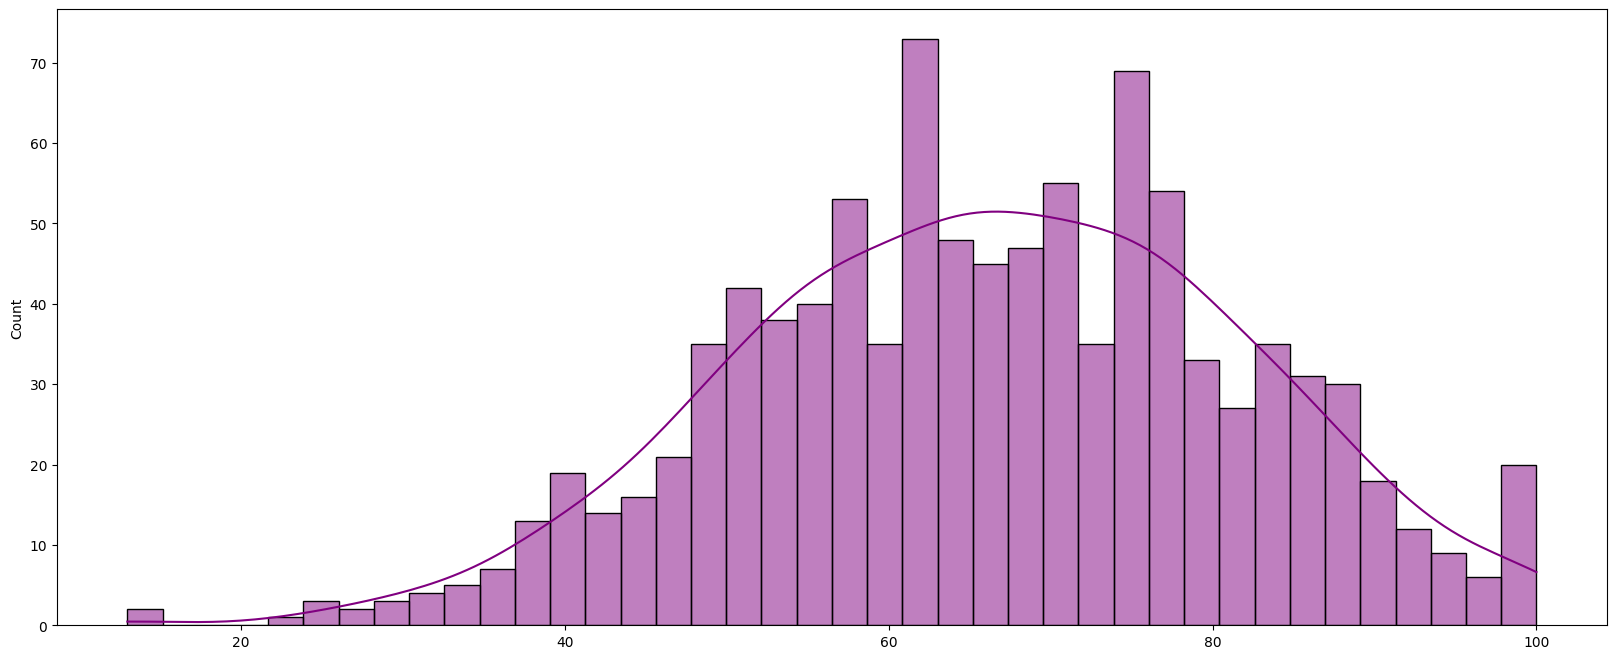

In [9]:
plt.figure(figsize=(20,8))
sns.histplot(data=df['math score'].values, color='purple', kde=True, bins=40, legend=True)

<Axes: xlabel='reading score', ylabel='Count'>

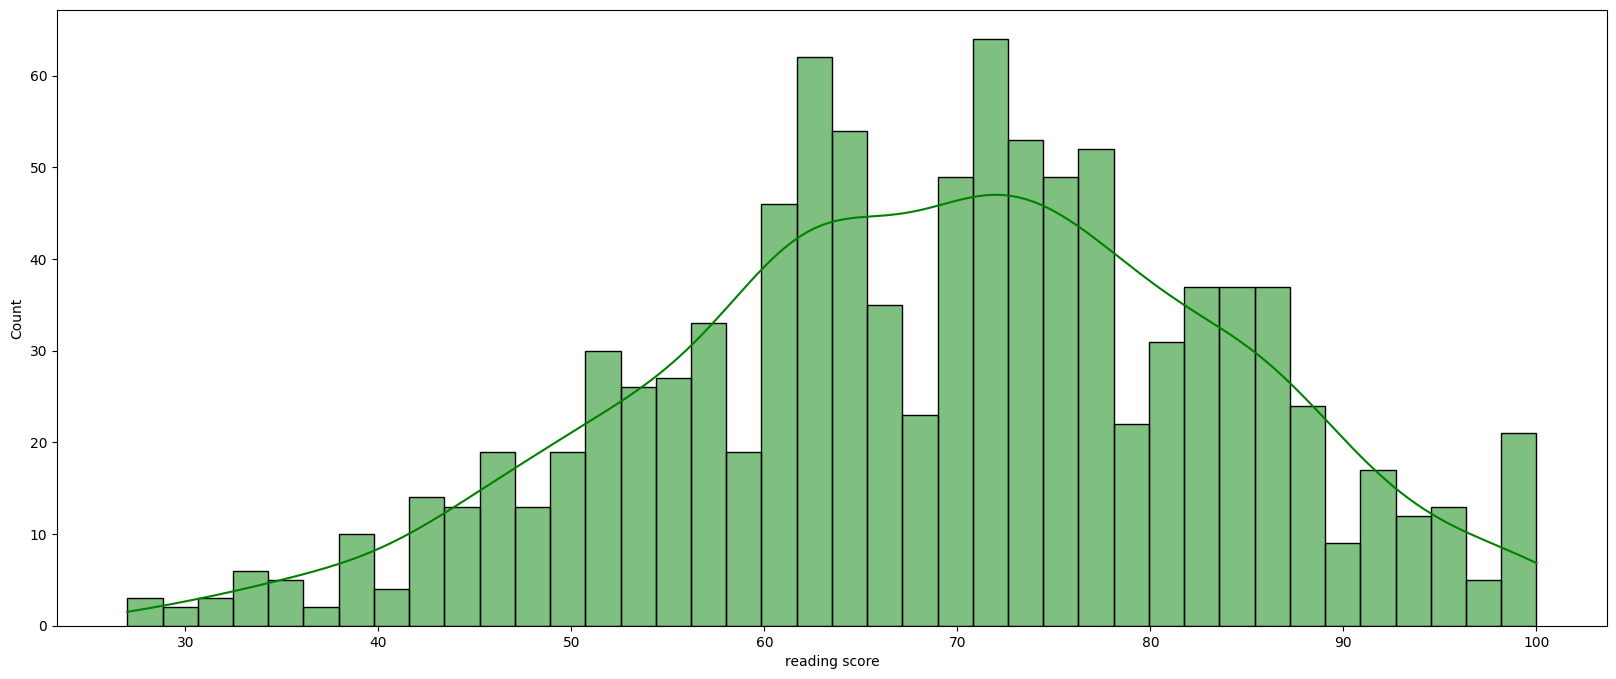

In [10]:
plt.figure(figsize=(20,8))
sns.histplot(data=df, x='reading score', color='green', kde=True, bins=40, legend=True)

<Axes: xlabel='writing score', ylabel='Count'>

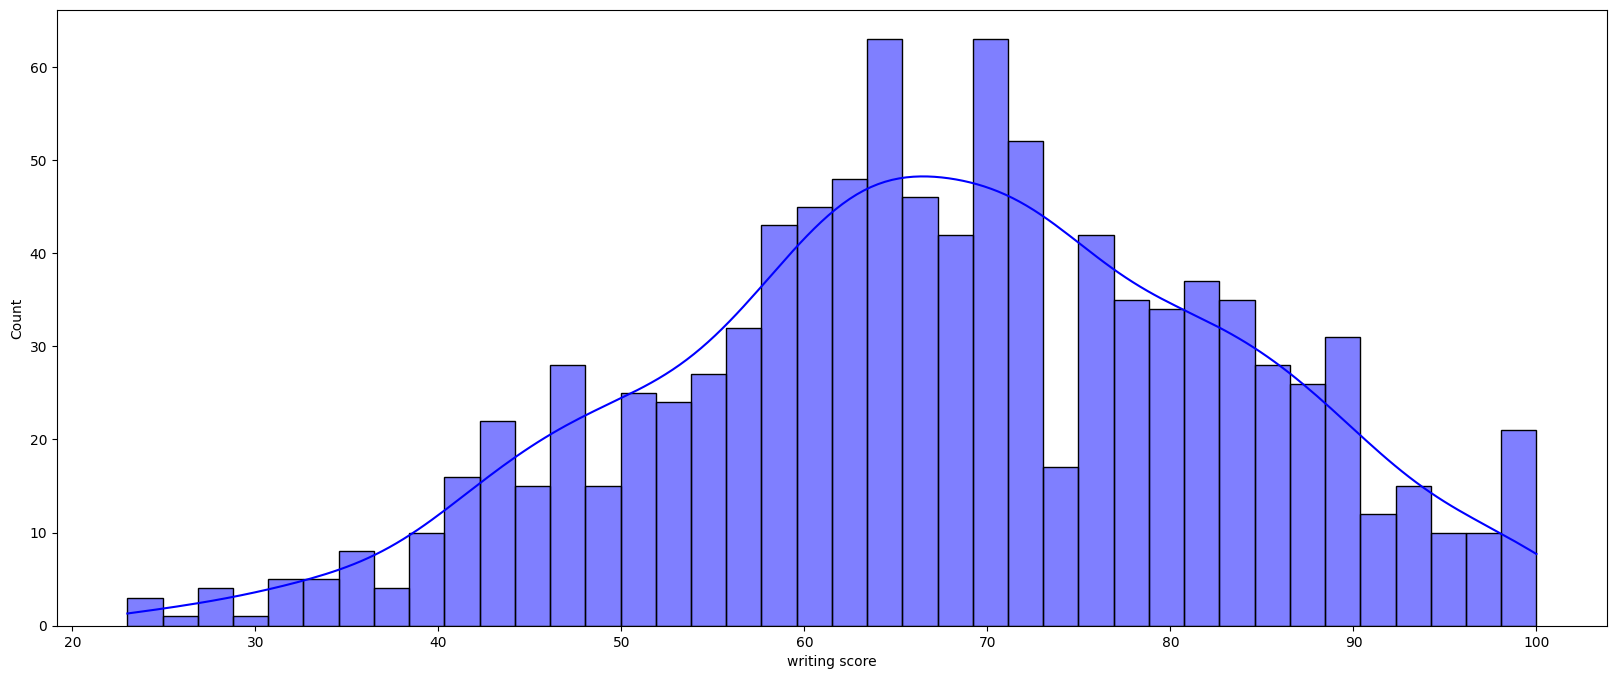

In [11]:
plt.figure(figsize=(20,8))
sns.histplot(data=df, x='writing score', color='blue', kde=True, bins=40, legend=True)

In [12]:
X = df.iloc[:, :-3]
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,male,group A,high school,standard,completed
1,female,group D,some high school,free/reduced,none
2,male,group E,some college,free/reduced,none
3,male,group B,high school,standard,none
4,male,group E,associate's degree,standard,completed


In [13]:
Y = df.iloc[:, -3:]
Y. head()

,math score,reading score,writing score
0,67,67,63
1,40,59,55
2,59,60,50
3,77,78,68
4,78,73,68


In [14]:
y = []
for _, row in Y.iterrows():
    if row.min() >= 60:
        y.append(1)
    else:
        y.append(-1)

y = np.array(y)

print('Number of students who passed:', len(y[y == 1]))
print('Ratio of students who passed:', len(y[y == 1]) / len(y))

Number of students who passed: 588
Ratio of students who passed: 0.588


We split the main column into feature columns and labels.

In [15]:
X_encoded = pd.get_dummies(X, columns=["gender",
                                        "race/ethnicity",
                                        "parental level of education",
                                        "lunch",
                                        "test preparation course"])
X_encoded.head()


,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,True,False
1,True,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True
2,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True
3,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True
4,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,True,False


We transform categorical variables into binary form.

In [16]:
X_encoded = X_encoded.to_numpy()
X_encoded = X_encoded.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y)

# Experiments conducted on the SVM algorithm using:
- Linear kernel
- Polynomial kernel
- RBF kernel

# Accuracy, confusion matrix, and precision for the linear kernel.

Accuracy: 0.66
Precision: 0.748
Recall: 0.664


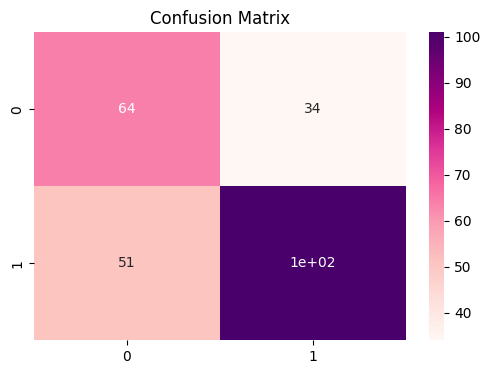

In [20]:
w, b = svm_fit(X_train, y_train, kernel_linear, C=1, epsilon=0.01, max_iter=1000, kernel_params={})

y_pred = predict(X_test, w, b)

print_values(y_test, y_pred)

Chart showing the dependency of accuracy, precision, and recall on the size of the testing set.

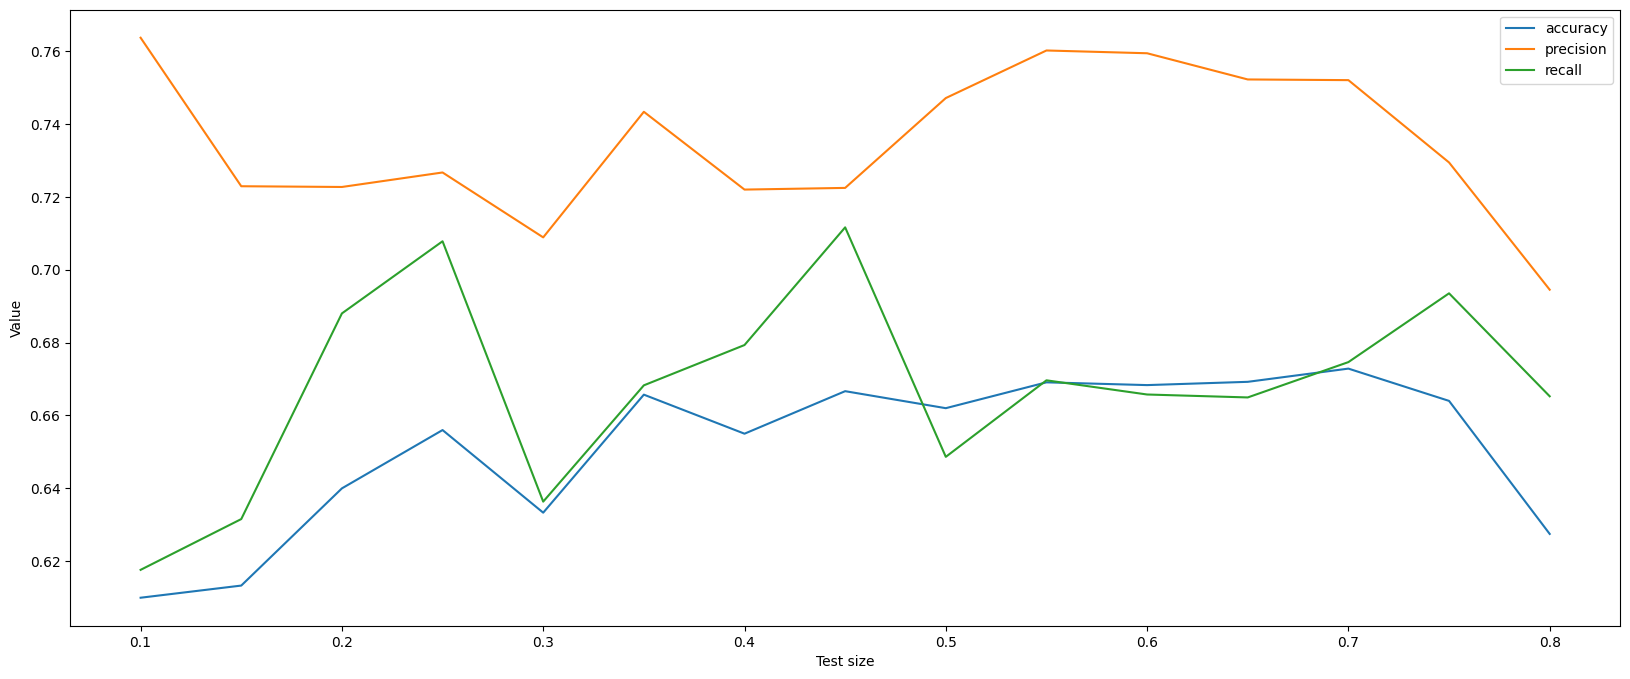

In [21]:
plot_for_test_size(kernel_linear, X_encoded, y)

Chart showing the dependency of accuracy on $C$.

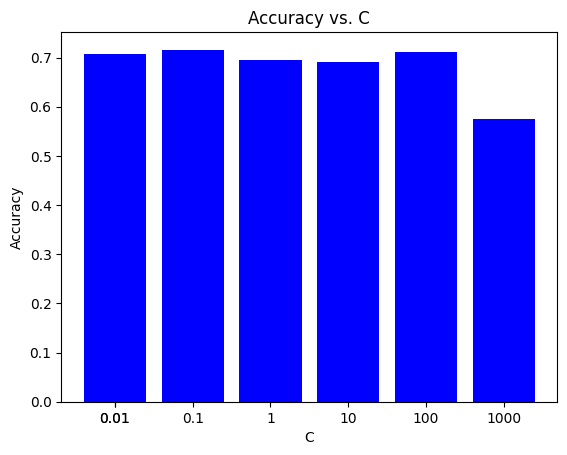

In [22]:
C_values = [0.01, 0.01, 0.1, 1, 10, 100, 1000]

accuracy_vector = np.zeros(len(C_values))

for i, C in enumerate(C_values):
    w, b = svm_fit(X_train, y_train, kernel_linear, C=C, epsilon=0.01, max_iter=1000, kernel_params={})
    
    y_pred = predict(X_test, w, b)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    accuracy_vector[i] = accuracy   

plt.bar(np.log10(C_values), accuracy_vector, color='blue')
plt.xticks(np.log10(C_values), C_values) 
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. C")
plt.show()

The accuracy of the result is minimally dependent on the value of C. For $C=1000$, the results noticeably deviate from the rest.

Comparison of the results of my implementation with Sklearn.

In [23]:
print('My implementation:')
w, b = svm_fit(X_train, y_train, kernel_linear, C=1, epsilon=0.01, max_iter=1000, kernel_params={})
y_pred = predict(X_test, w, b)
print_values(y_test, y_pred, matrix=False)

print('------------------------------------')

print('Sklearn implementation:')
clf_svm = SVC(kernel='linear',C=1.0)
clf_svm.fit(X_train,y_train)
y_pred = clf_svm.predict(X_test)

print_values(y_test, y_pred, matrix=False)

My implementation:
Accuracy: 0.692
Precision: 0.766
Recall: 0.711
------------------------------------
Sklearn implementation:
Accuracy: 0.672
Precision: 0.719
Recall: 0.757


# Accuracy, confusion matrix, and precision for the polynomial kernel.

Accuracy: 0.7
Precision: 0.718
Recall: 0.836


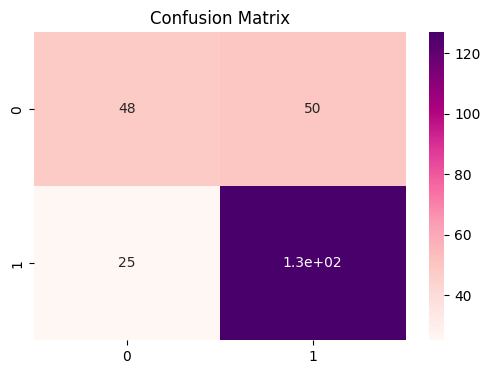

In [24]:
w, b = svm_fit(X_train, y_train, kernel_polynomial, C=1, epsilon=0.01, max_iter=1000, kernel_params={'p': 3})
y_pred = predict(X_test, w, b)

print_values(y_test, y_pred)

Chart showing the dependency of accuracy, precision, and recall on the size of the testing set.

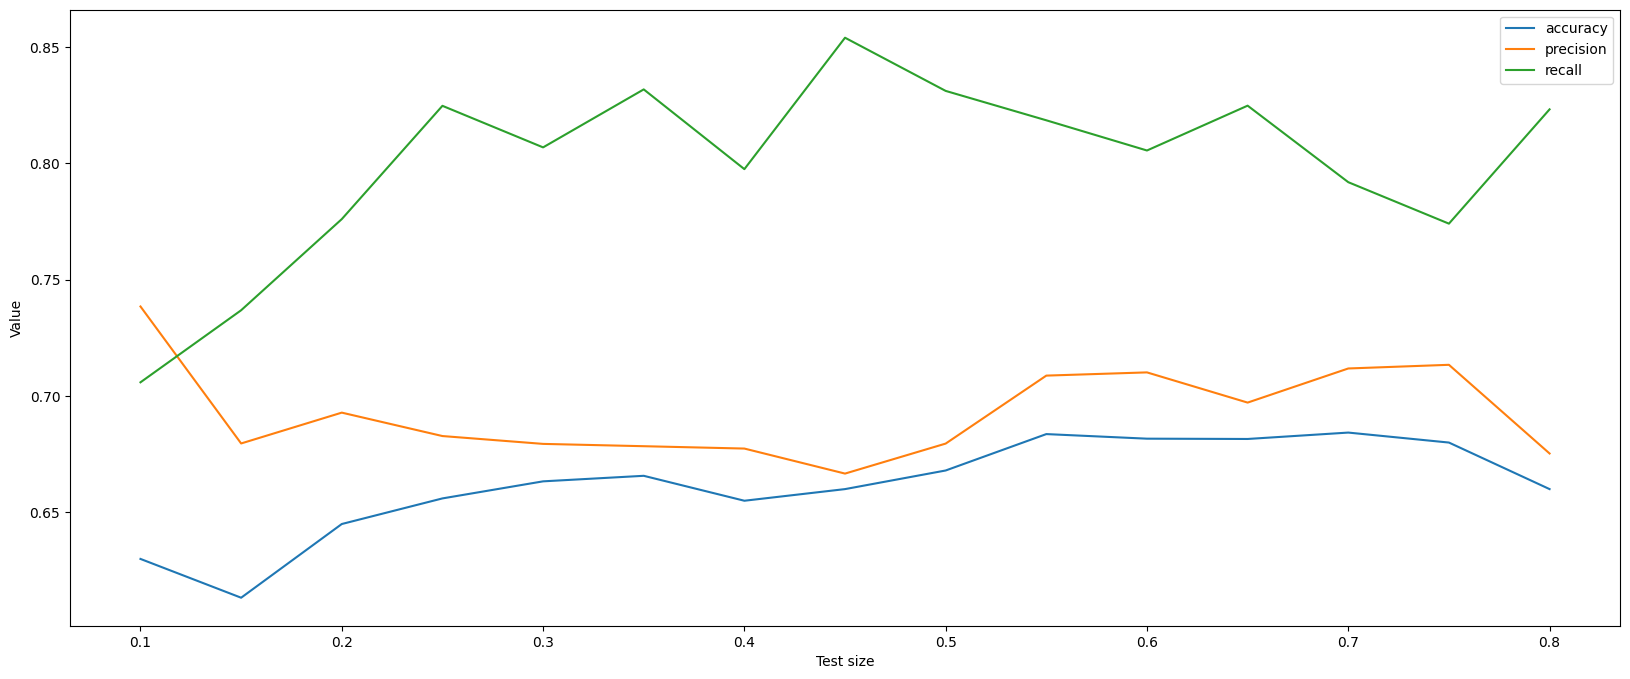

In [25]:
plot_for_test_size(kernel_polynomial, X_encoded, y)

Map showing the dependency of accuracy on $C$ and the polynomial degree.

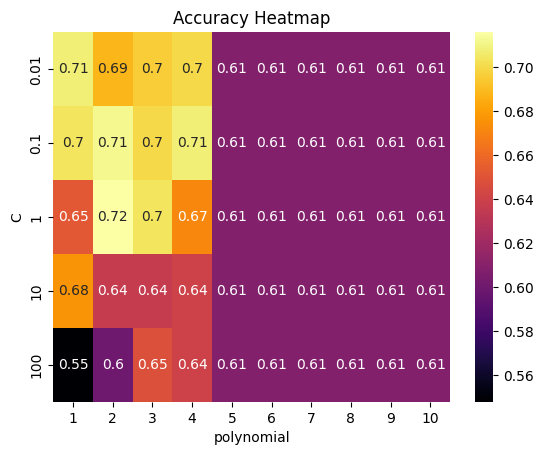

In [26]:
C_values = [0.01, 0.1, 1, 10, 100]
polynomial_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

accuracy_matrix = np.zeros((len(C_values), len(polynomial_values)))

for i, C in enumerate(C_values):
    for j, polynomial in enumerate(polynomial_values):
        w, b = svm_fit(X_train, y_train, kernel_polynomial, C=C, epsilon=0.01, max_iter=100, kernel_params={'p': polynomial})
        
        y_pred = predict(X_test, w, b)
        
        accuracy = metrics.accuracy_score(y_test, y_pred)
        
        accuracy_matrix[i, j] = accuracy

sns.heatmap(accuracy_matrix, annot=True, xticklabels=polynomial_values, yticklabels=C_values, cmap="inferno")
plt.xlabel("polynomial")
plt.ylabel("C")
plt.title("Accuracy Heatmap")
plt.show()

On the presented map, we observe that the highest accuracy is achieved for a polynomial of degree 2 with $C=0.1$. For degrees greater than 4, the accuracy remains constant regardless of $C$.

Comparison of the results of my implementation with Sklearn.

In [27]:
print('My implementation:')
w, b = svm_fit(X_train, y_train, kernel_polynomial, C=1, epsilon=0.01, max_iter=1000, kernel_params={'p': 3})
y_pred = predict(X_test, w, b)
print_values(y_test, y_pred, matrix=False)

print('------------------------------------')

print('Sklearn implementation:')
clf_svm = SVC(kernel='poly', degree=3, C=1.0)
clf_svm.fit(X_train,y_train)
y_pred = clf_svm.predict(X_test)

print_values(y_test, y_pred, matrix=False)

My implementation:
Accuracy: 0.7
Precision: 0.715
Recall: 0.842
------------------------------------
Sklearn implementation:
Accuracy: 0.656
Precision: 0.699
Recall: 0.763


# Accuracy, confusion matrix, and precision for the RBF kernel.

Accuracy: 0.668
Precision: 0.738
Recall: 0.704


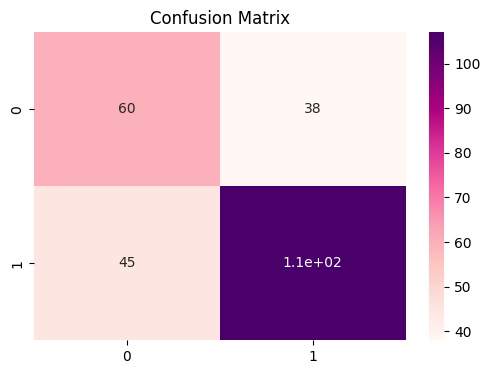

In [28]:
w, b = svm_fit(X_train, y_train, kernel_RBF, C=1, epsilon=0.01, max_iter=100, kernel_params={'gamma': 0.1})
y_pred = predict(X_test, w, b)

print_values(y_test, y_pred)

Chart showing the dependency of accuracy, precision, and recall on the size of the testing set.

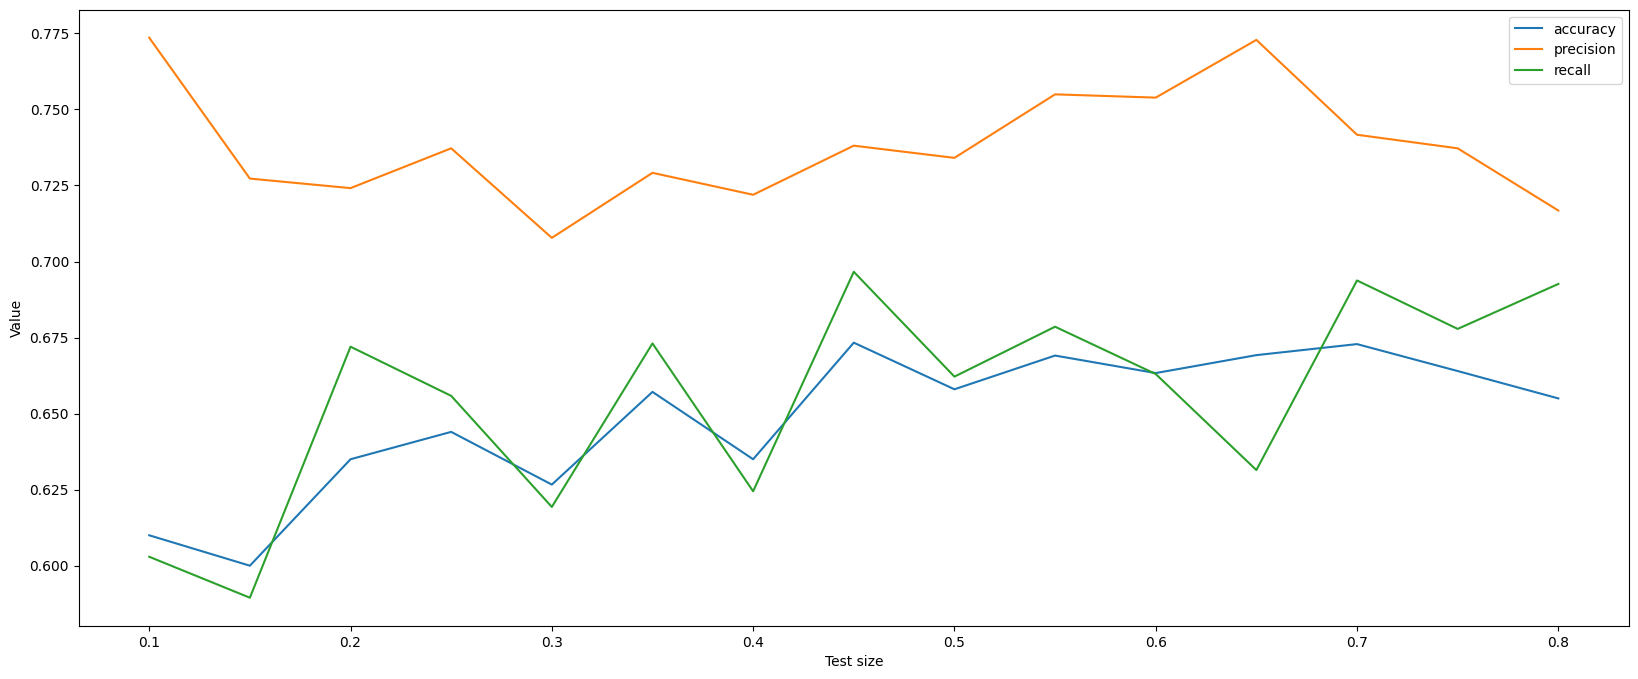

In [29]:
plot_for_test_size(kernel_RBF, X_encoded, y)

Heatmap showing the dependency of accuracy on $C$ and the gamma coefficient.

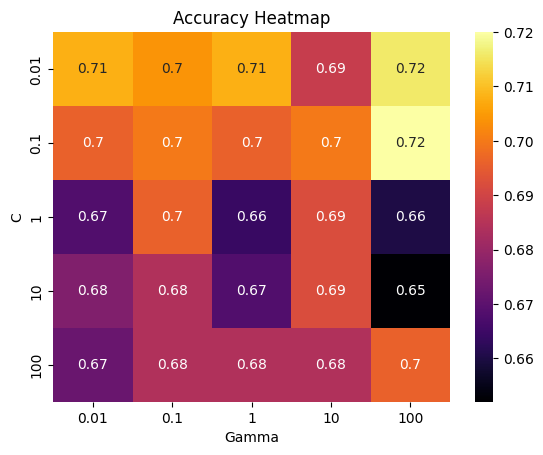

In [30]:
C_values = [0.01, 0.1, 1, 10, 100]
gamma_values = [0.01, 0.1, 1, 10, 100]

accuracy_matrix = np.zeros((len(C_values), len(gamma_values)))

for i, C in enumerate(C_values):
    for j, gamma in enumerate(gamma_values):
        w, b = svm_fit(X_train, y_train, kernel_RBF, C=C, epsilon=0.01, max_iter=100, kernel_params={'gamma': gamma})
        
        y_pred = predict(X_test, w, b)
        
        accuracy = metrics.accuracy_score(y_test, y_pred)
        
        accuracy_matrix[i, j] = accuracy

sns.heatmap(accuracy_matrix, annot=True, xticklabels=gamma_values, yticklabels=C_values, cmap="inferno")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.title("Accuracy Heatmap")
plt.show()


The most accurate result is obtained for gamma=10 and $C=100$.

Comparison of the results of my implementation with Sklearn.

In [31]:
print('My implementation:')
w, b = svm_fit(X_train, y_train, kernel_RBF, C=1, epsilon=0.01, max_iter=1000, kernel_params={'gamma': 0.1})
y_pred = predict(X_test, w, b)
print_values(y_test, y_pred, matrix=False)

print('------------------------------------')

print('Sklearn implementation:')
clf_svm = SVC(kernel='rbf', gamma=0.1, C=1.0)
clf_svm.fit(X_train,y_train)
y_pred = clf_svm.predict(X_test)

print_values(y_test, y_pred, matrix=False)

My implementation:
Accuracy: 0.684
Precision: 0.759
Recall: 0.704
------------------------------------
Sklearn implementation:
Accuracy: 0.692
Precision: 0.725
Recall: 0.796
